# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

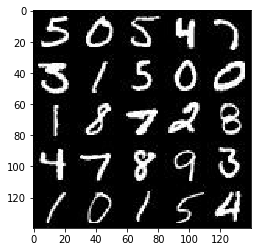

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

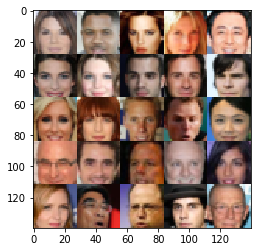

In [3]:

show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))



## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:14: UserWarning: No GPU found. Please use a GPU to train your neural network.
  


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    real_inputs = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels),
                                'real_inputs')
    z_inputs = tf.placeholder(tf.float32, (None, z_dim), 'z_inputs')
    learning_rate = tf.placeholder(tf.float32, name='learning_rate')

    return real_inputs, z_inputs, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed



### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    with tf.variable_scope('discriminator', reuse=reuse):
        
        alpha = 0.2
        
        h1 = tf.layers.conv2d(images, 64, 5, 2, 'same')
        h1 = tf.maximum(alpha * h1, h1)
        
        h2 = tf.layers.conv2d(h1, 128, 5, 2, 'same')
        h2 = tf.layers.batch_normalization(h2, training=True)
        h2 = tf.maximum(alpha * h2, h2)
        
        h3 = tf.layers.conv2d(h2, 256, 5, 2, 'same')
        h3 = tf.layers.batch_normalization(h3, training=True)
        h3 = tf.maximum(alpha * h3, h3)
        
        flat = tf.reshape(h3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    
    with tf.variable_scope('generator', reuse=not is_train):
        alpha = 0.2
    
        h1 = tf.layers.dense(z, 2*2*512)
        h1 = tf.reshape(h1, (-1, 2, 2, 512))
        h1 = tf.layers.batch_normalization(h1, training=is_train)
        h1 = tf.maximum(alpha * h1, h1)
    
        h2 = tf.layers.conv2d_transpose(h1, 256, 5, 2, 'valid')
        h2 = tf.layers.batch_normalization(h2, training=is_train)
        h2 = tf.maximum(alpha * h2, h2)
    
        h3 = tf.layers.conv2d_transpose(h2, 128, 5, 2, 'same')
        h3 = tf.layers.batch_normalization(h3, training=is_train)
        h3 = tf.maximum(alpha * h3, h3)
    
        logits = tf.layers.conv2d_transpose(h3, out_channel_dim, 5, 2, 'same')
        out = tf.tanh(logits)
    
        return out

    
    

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    
    
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(
        logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    
    g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(
        logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))
    
    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    
    d_train_opt = tf.train.AdamOptimizer(
        learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
    
    ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    g_updates = [opt for opt in ops if opt.name.startswith('generator')]
    with tf.control_dependencies(g_updates):
        g_train_opt = tf.train.AdamOptimizer(
            learning_rate, beta1).minimize(g_loss, var_list=g_vars)
        
    return d_train_opt, g_train_opt

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)



Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    
    real_input, z_input, lr = model_inputs(
        data_shape[1], data_shape[2], data_shape[3], z_dim)
    
    d_loss, g_loss = model_loss(real_input, z_input, data_shape[3])
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    steps = 0
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1
                batch_images *= 2.0
                z_sample = np.random.uniform(-1, 1, (batch_size, z_dim))
                
                _ = sess.run(d_opt, feed_dict={
                        real_input: batch_images, z_input: z_sample, lr: learning_rate})
                _ = sess.run(g_opt, feed_dict={
                        z_input: z_sample, lr: learning_rate})
                
                if steps % 10 == 0:
                    train_loss_d = d_loss.eval({z_input: z_sample, real_input: batch_images})
                    train_loss_g = g_loss.eval({z_input: z_sample})
                    
                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                
                if steps % 100 == 0:
                    show_generator_output(sess, show_n_images, z_input, data_shape[3], data_image_mode)


### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the lo
ss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 0.0501... Generator Loss: 8.1655
Epoch 1/2... Discriminator Loss: 2.8373... Generator Loss: 0.0657
Epoch 1/2... Discriminator Loss: 5.7606... Generator Loss: 0.0059
Epoch 1/2... Discriminator Loss: 0.1381... Generator Loss: 2.6758
Epoch 1/2... Discriminator Loss: 0.0465... Generator Loss: 4.1459
Epoch 1/2... Discriminator Loss: 0.4963... Generator Loss: 1.1966
Epoch 1/2... Discriminator Loss: 2.0274... Generator Loss: 0.7468
Epoch 1/2... Discriminator Loss: 0.4269... Generator Loss: 2.9316
Epoch 1/2... Discriminator Loss: 0.3033... Generator Loss: 2.3718
Epoch 1/2... Discriminator Loss: 2.4496... Generator Loss: 10.5731


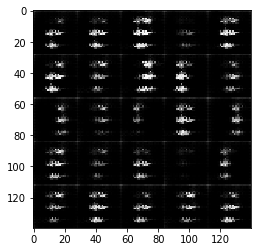

Epoch 1/2... Discriminator Loss: 0.3330... Generator Loss: 3.2601
Epoch 1/2... Discriminator Loss: 0.3739... Generator Loss: 2.6331
Epoch 1/2... Discriminator Loss: 0.3182... Generator Loss: 1.7953
Epoch 1/2... Discriminator Loss: 0.1717... Generator Loss: 5.1444
Epoch 1/2... Discriminator Loss: 1.1026... Generator Loss: 0.7698
Epoch 1/2... Discriminator Loss: 0.1163... Generator Loss: 5.8390
Epoch 1/2... Discriminator Loss: 0.1340... Generator Loss: 5.1604
Epoch 1/2... Discriminator Loss: 0.2168... Generator Loss: 2.6483
Epoch 1/2... Discriminator Loss: 2.3840... Generator Loss: 10.2745
Epoch 1/2... Discriminator Loss: 0.9714... Generator Loss: 0.8213


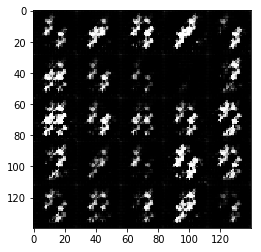

Epoch 1/2... Discriminator Loss: 0.5653... Generator Loss: 1.6629
Epoch 1/2... Discriminator Loss: 0.4760... Generator Loss: 1.7983
Epoch 1/2... Discriminator Loss: 0.5487... Generator Loss: 2.0096
Epoch 1/2... Discriminator Loss: 0.5175... Generator Loss: 1.8100
Epoch 1/2... Discriminator Loss: 0.3939... Generator Loss: 1.9332
Epoch 1/2... Discriminator Loss: 1.9932... Generator Loss: 7.7471
Epoch 1/2... Discriminator Loss: 0.6865... Generator Loss: 1.4425
Epoch 1/2... Discriminator Loss: 0.6232... Generator Loss: 1.2644
Epoch 1/2... Discriminator Loss: 0.7429... Generator Loss: 1.3978
Epoch 1/2... Discriminator Loss: 1.0574... Generator Loss: 0.9729


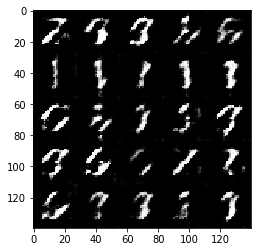

Epoch 1/2... Discriminator Loss: 0.4516... Generator Loss: 2.7289
Epoch 1/2... Discriminator Loss: 0.6018... Generator Loss: 1.7409
Epoch 1/2... Discriminator Loss: 0.3760... Generator Loss: 1.8787
Epoch 1/2... Discriminator Loss: 1.7165... Generator Loss: 5.3897
Epoch 1/2... Discriminator Loss: 0.8601... Generator Loss: 2.5379
Epoch 1/2... Discriminator Loss: 0.5001... Generator Loss: 1.4405
Epoch 1/2... Discriminator Loss: 0.3649... Generator Loss: 2.8600
Epoch 1/2... Discriminator Loss: 1.0096... Generator Loss: 2.2052
Epoch 1/2... Discriminator Loss: 1.0226... Generator Loss: 1.2537
Epoch 1/2... Discriminator Loss: 0.9227... Generator Loss: 0.8942


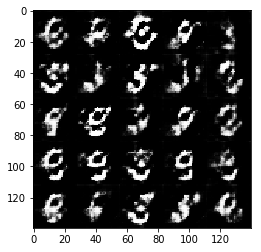

Epoch 1/2... Discriminator Loss: 0.7241... Generator Loss: 2.3345
Epoch 1/2... Discriminator Loss: 0.8250... Generator Loss: 1.4239
Epoch 1/2... Discriminator Loss: 1.3087... Generator Loss: 0.8676
Epoch 1/2... Discriminator Loss: 0.8310... Generator Loss: 1.7061
Epoch 1/2... Discriminator Loss: 0.6904... Generator Loss: 1.1684
Epoch 1/2... Discriminator Loss: 0.6162... Generator Loss: 2.0228
Epoch 1/2... Discriminator Loss: 0.6339... Generator Loss: 1.7839
Epoch 1/2... Discriminator Loss: 0.7855... Generator Loss: 1.9174
Epoch 1/2... Discriminator Loss: 0.6555... Generator Loss: 1.5220
Epoch 1/2... Discriminator Loss: 0.7853... Generator Loss: 1.1502


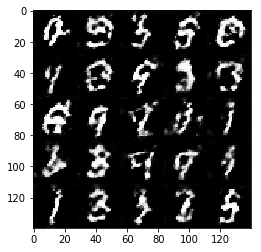

Epoch 1/2... Discriminator Loss: 0.7670... Generator Loss: 1.0312
Epoch 1/2... Discriminator Loss: 0.7096... Generator Loss: 1.1200
Epoch 1/2... Discriminator Loss: 1.7935... Generator Loss: 0.3232
Epoch 1/2... Discriminator Loss: 0.8355... Generator Loss: 2.4586
Epoch 1/2... Discriminator Loss: 0.7295... Generator Loss: 1.3370
Epoch 1/2... Discriminator Loss: 0.7292... Generator Loss: 1.4024
Epoch 1/2... Discriminator Loss: 0.7433... Generator Loss: 1.3304
Epoch 1/2... Discriminator Loss: 0.9475... Generator Loss: 1.1141
Epoch 1/2... Discriminator Loss: 1.0068... Generator Loss: 2.3466
Epoch 1/2... Discriminator Loss: 0.7500... Generator Loss: 2.4365


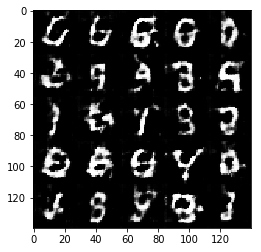

Epoch 1/2... Discriminator Loss: 0.9054... Generator Loss: 1.6418
Epoch 1/2... Discriminator Loss: 1.0165... Generator Loss: 0.7102
Epoch 1/2... Discriminator Loss: 0.7021... Generator Loss: 1.0846
Epoch 1/2... Discriminator Loss: 0.7833... Generator Loss: 1.4944
Epoch 1/2... Discriminator Loss: 1.1964... Generator Loss: 0.7498
Epoch 1/2... Discriminator Loss: 0.6483... Generator Loss: 1.4554
Epoch 1/2... Discriminator Loss: 0.7119... Generator Loss: 1.3835
Epoch 1/2... Discriminator Loss: 0.9255... Generator Loss: 0.8400
Epoch 1/2... Discriminator Loss: 0.8702... Generator Loss: 1.8025
Epoch 1/2... Discriminator Loss: 0.8126... Generator Loss: 1.4350


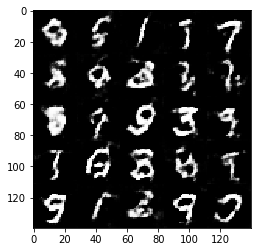

Epoch 1/2... Discriminator Loss: 0.6472... Generator Loss: 1.1835
Epoch 1/2... Discriminator Loss: 0.7656... Generator Loss: 2.0266
Epoch 1/2... Discriminator Loss: 0.7320... Generator Loss: 1.1525
Epoch 1/2... Discriminator Loss: 0.7755... Generator Loss: 2.0036
Epoch 1/2... Discriminator Loss: 0.8130... Generator Loss: 1.0396
Epoch 1/2... Discriminator Loss: 0.8397... Generator Loss: 1.0121
Epoch 1/2... Discriminator Loss: 1.1224... Generator Loss: 1.0047
Epoch 1/2... Discriminator Loss: 1.1208... Generator Loss: 0.8434
Epoch 1/2... Discriminator Loss: 0.7486... Generator Loss: 1.2972
Epoch 1/2... Discriminator Loss: 0.7221... Generator Loss: 1.4366


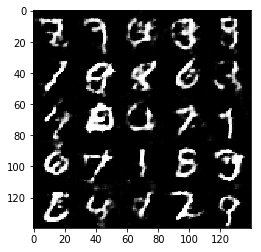

Epoch 1/2... Discriminator Loss: 0.9744... Generator Loss: 1.2762
Epoch 1/2... Discriminator Loss: 1.0545... Generator Loss: 0.6565
Epoch 1/2... Discriminator Loss: 1.4745... Generator Loss: 0.3588
Epoch 1/2... Discriminator Loss: 1.3043... Generator Loss: 0.4826
Epoch 1/2... Discriminator Loss: 1.1934... Generator Loss: 0.5381
Epoch 1/2... Discriminator Loss: 0.7268... Generator Loss: 2.0262
Epoch 1/2... Discriminator Loss: 1.0055... Generator Loss: 0.8706
Epoch 1/2... Discriminator Loss: 0.8395... Generator Loss: 1.3066
Epoch 1/2... Discriminator Loss: 0.9130... Generator Loss: 1.1958
Epoch 1/2... Discriminator Loss: 1.0402... Generator Loss: 0.6293


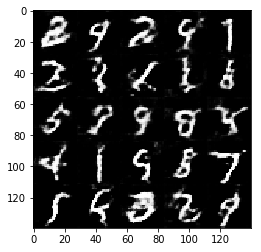

Epoch 1/2... Discriminator Loss: 1.1766... Generator Loss: 0.5830
Epoch 1/2... Discriminator Loss: 1.0708... Generator Loss: 0.5999
Epoch 1/2... Discriminator Loss: 1.1966... Generator Loss: 0.6033
Epoch 1/2... Discriminator Loss: 0.9895... Generator Loss: 0.7862
Epoch 1/2... Discriminator Loss: 1.0802... Generator Loss: 0.6607
Epoch 1/2... Discriminator Loss: 1.2761... Generator Loss: 0.7682
Epoch 1/2... Discriminator Loss: 0.7229... Generator Loss: 1.2686
Epoch 1/2... Discriminator Loss: 0.8259... Generator Loss: 0.8996
Epoch 1/2... Discriminator Loss: 0.8199... Generator Loss: 1.2705
Epoch 1/2... Discriminator Loss: 0.7830... Generator Loss: 1.3769


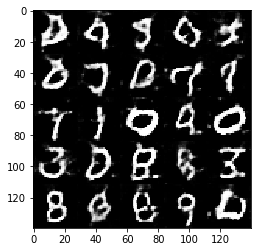

Epoch 1/2... Discriminator Loss: 1.0660... Generator Loss: 1.7432
Epoch 1/2... Discriminator Loss: 0.9772... Generator Loss: 0.9591
Epoch 1/2... Discriminator Loss: 1.0538... Generator Loss: 1.9422
Epoch 1/2... Discriminator Loss: 0.9333... Generator Loss: 1.0531
Epoch 1/2... Discriminator Loss: 1.0927... Generator Loss: 1.0720
Epoch 1/2... Discriminator Loss: 0.8057... Generator Loss: 1.0188
Epoch 1/2... Discriminator Loss: 1.0638... Generator Loss: 1.4384
Epoch 1/2... Discriminator Loss: 0.9642... Generator Loss: 0.7462
Epoch 1/2... Discriminator Loss: 0.9514... Generator Loss: 0.6044
Epoch 1/2... Discriminator Loss: 0.8091... Generator Loss: 1.1976


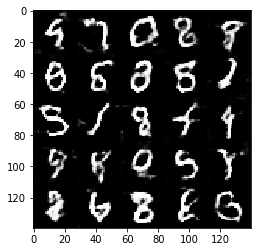

Epoch 1/2... Discriminator Loss: 0.6529... Generator Loss: 1.1987
Epoch 1/2... Discriminator Loss: 1.3226... Generator Loss: 2.2779
Epoch 1/2... Discriminator Loss: 1.0335... Generator Loss: 1.8592
Epoch 1/2... Discriminator Loss: 0.9056... Generator Loss: 1.3140
Epoch 1/2... Discriminator Loss: 1.7886... Generator Loss: 0.2328
Epoch 1/2... Discriminator Loss: 0.9422... Generator Loss: 1.2169
Epoch 1/2... Discriminator Loss: 1.0470... Generator Loss: 1.0776
Epoch 1/2... Discriminator Loss: 0.9613... Generator Loss: 0.7922
Epoch 1/2... Discriminator Loss: 0.9540... Generator Loss: 0.8893
Epoch 1/2... Discriminator Loss: 0.7624... Generator Loss: 1.9772


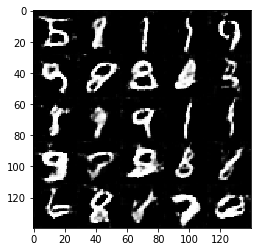

Epoch 1/2... Discriminator Loss: 0.9673... Generator Loss: 0.8427
Epoch 1/2... Discriminator Loss: 0.9529... Generator Loss: 0.9949
Epoch 1/2... Discriminator Loss: 1.3872... Generator Loss: 0.5251
Epoch 1/2... Discriminator Loss: 0.8232... Generator Loss: 1.5125
Epoch 1/2... Discriminator Loss: 1.3014... Generator Loss: 0.5157
Epoch 1/2... Discriminator Loss: 0.7584... Generator Loss: 1.3675
Epoch 1/2... Discriminator Loss: 0.8495... Generator Loss: 1.6835
Epoch 1/2... Discriminator Loss: 0.7205... Generator Loss: 1.4573
Epoch 1/2... Discriminator Loss: 0.6298... Generator Loss: 1.3186
Epoch 1/2... Discriminator Loss: 1.7398... Generator Loss: 0.3284


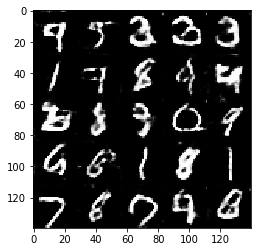

Epoch 1/2... Discriminator Loss: 0.8689... Generator Loss: 1.7306
Epoch 1/2... Discriminator Loss: 1.1380... Generator Loss: 0.5392
Epoch 1/2... Discriminator Loss: 0.7313... Generator Loss: 1.0364
Epoch 1/2... Discriminator Loss: 0.7911... Generator Loss: 1.5160
Epoch 1/2... Discriminator Loss: 1.4426... Generator Loss: 0.4045
Epoch 1/2... Discriminator Loss: 1.5597... Generator Loss: 0.3401
Epoch 1/2... Discriminator Loss: 0.9998... Generator Loss: 1.0054
Epoch 1/2... Discriminator Loss: 1.6768... Generator Loss: 0.3498
Epoch 1/2... Discriminator Loss: 1.0695... Generator Loss: 0.6716
Epoch 1/2... Discriminator Loss: 1.2703... Generator Loss: 0.4416


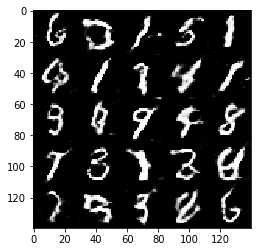

Epoch 1/2... Discriminator Loss: 1.5087... Generator Loss: 0.4029
Epoch 1/2... Discriminator Loss: 0.9603... Generator Loss: 0.7955
Epoch 1/2... Discriminator Loss: 0.8315... Generator Loss: 1.7741
Epoch 1/2... Discriminator Loss: 0.4475... Generator Loss: 1.9348
Epoch 1/2... Discriminator Loss: 1.1993... Generator Loss: 0.6575
Epoch 1/2... Discriminator Loss: 0.9556... Generator Loss: 0.7055
Epoch 1/2... Discriminator Loss: 1.0334... Generator Loss: 1.9832
Epoch 1/2... Discriminator Loss: 0.7540... Generator Loss: 1.2674
Epoch 1/2... Discriminator Loss: 1.0308... Generator Loss: 0.5971
Epoch 1/2... Discriminator Loss: 1.8713... Generator Loss: 0.2634


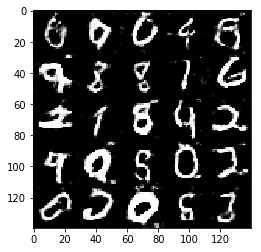

Epoch 1/2... Discriminator Loss: 1.3308... Generator Loss: 0.4713
Epoch 1/2... Discriminator Loss: 1.1129... Generator Loss: 0.6779
Epoch 1/2... Discriminator Loss: 1.4015... Generator Loss: 0.3828
Epoch 1/2... Discriminator Loss: 0.8379... Generator Loss: 1.7838
Epoch 1/2... Discriminator Loss: 1.6204... Generator Loss: 0.2758
Epoch 1/2... Discriminator Loss: 0.8464... Generator Loss: 1.8703
Epoch 1/2... Discriminator Loss: 0.4476... Generator Loss: 1.9511
Epoch 1/2... Discriminator Loss: 0.7008... Generator Loss: 1.3415
Epoch 1/2... Discriminator Loss: 1.1512... Generator Loss: 0.7405
Epoch 1/2... Discriminator Loss: 1.7257... Generator Loss: 0.3251


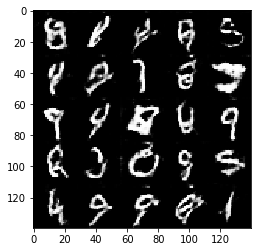

Epoch 1/2... Discriminator Loss: 0.8754... Generator Loss: 1.2140
Epoch 1/2... Discriminator Loss: 0.8803... Generator Loss: 0.8274
Epoch 1/2... Discriminator Loss: 1.0739... Generator Loss: 0.6407
Epoch 1/2... Discriminator Loss: 0.8595... Generator Loss: 1.0944
Epoch 1/2... Discriminator Loss: 1.6155... Generator Loss: 0.3262
Epoch 1/2... Discriminator Loss: 0.6849... Generator Loss: 1.1123
Epoch 1/2... Discriminator Loss: 0.9422... Generator Loss: 0.7256
Epoch 1/2... Discriminator Loss: 1.3485... Generator Loss: 0.4958
Epoch 1/2... Discriminator Loss: 0.7100... Generator Loss: 1.0723
Epoch 1/2... Discriminator Loss: 0.8684... Generator Loss: 0.8611


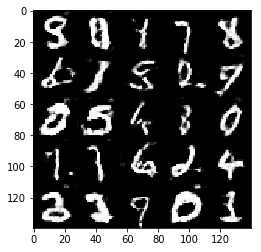

Epoch 1/2... Discriminator Loss: 1.2913... Generator Loss: 0.4677
Epoch 1/2... Discriminator Loss: 1.3243... Generator Loss: 0.7209
Epoch 1/2... Discriminator Loss: 1.0313... Generator Loss: 2.0635
Epoch 1/2... Discriminator Loss: 1.0337... Generator Loss: 0.9533
Epoch 1/2... Discriminator Loss: 1.7386... Generator Loss: 0.2906
Epoch 1/2... Discriminator Loss: 1.3419... Generator Loss: 0.4210
Epoch 1/2... Discriminator Loss: 0.8945... Generator Loss: 0.8901
Epoch 1/2... Discriminator Loss: 0.7032... Generator Loss: 1.5272
Epoch 1/2... Discriminator Loss: 0.9057... Generator Loss: 1.0354
Epoch 1/2... Discriminator Loss: 0.6423... Generator Loss: 1.2637


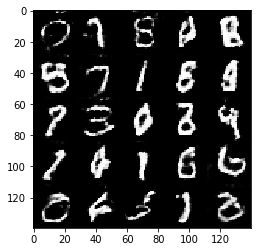

Epoch 1/2... Discriminator Loss: 1.3328... Generator Loss: 0.4723
Epoch 1/2... Discriminator Loss: 1.7753... Generator Loss: 0.3273
Epoch 1/2... Discriminator Loss: 0.6901... Generator Loss: 1.6209
Epoch 1/2... Discriminator Loss: 0.8800... Generator Loss: 0.9517
Epoch 1/2... Discriminator Loss: 1.0563... Generator Loss: 0.5710
Epoch 1/2... Discriminator Loss: 0.6575... Generator Loss: 0.9975
Epoch 1/2... Discriminator Loss: 2.1770... Generator Loss: 0.2294
Epoch 2/2... Discriminator Loss: 1.3057... Generator Loss: 0.5388
Epoch 2/2... Discriminator Loss: 1.1096... Generator Loss: 0.7614
Epoch 2/2... Discriminator Loss: 0.9753... Generator Loss: 0.7748


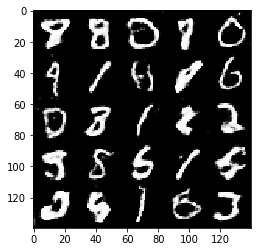

Epoch 2/2... Discriminator Loss: 1.3626... Generator Loss: 0.4173
Epoch 2/2... Discriminator Loss: 0.4042... Generator Loss: 1.6825
Epoch 2/2... Discriminator Loss: 0.7352... Generator Loss: 0.8910
Epoch 2/2... Discriminator Loss: 0.6149... Generator Loss: 1.7745
Epoch 2/2... Discriminator Loss: 2.6266... Generator Loss: 0.1384
Epoch 2/2... Discriminator Loss: 1.2154... Generator Loss: 0.5315
Epoch 2/2... Discriminator Loss: 0.6550... Generator Loss: 1.1224
Epoch 2/2... Discriminator Loss: 0.8222... Generator Loss: 1.9628
Epoch 2/2... Discriminator Loss: 0.5932... Generator Loss: 1.3030
Epoch 2/2... Discriminator Loss: 1.6980... Generator Loss: 0.4013


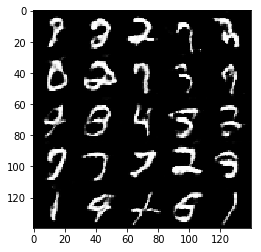

Epoch 2/2... Discriminator Loss: 1.6536... Generator Loss: 0.3654
Epoch 2/2... Discriminator Loss: 0.6772... Generator Loss: 2.5592
Epoch 2/2... Discriminator Loss: 1.7187... Generator Loss: 0.2803
Epoch 2/2... Discriminator Loss: 1.8698... Generator Loss: 0.3119
Epoch 2/2... Discriminator Loss: 1.8027... Generator Loss: 0.2784
Epoch 2/2... Discriminator Loss: 0.9798... Generator Loss: 1.1971
Epoch 2/2... Discriminator Loss: 0.6946... Generator Loss: 1.1409
Epoch 2/2... Discriminator Loss: 1.2111... Generator Loss: 0.5342
Epoch 2/2... Discriminator Loss: 1.0996... Generator Loss: 3.0539
Epoch 2/2... Discriminator Loss: 0.4268... Generator Loss: 1.5928


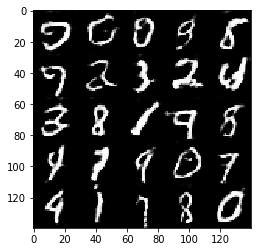

Epoch 2/2... Discriminator Loss: 1.9810... Generator Loss: 0.3339
Epoch 2/2... Discriminator Loss: 3.2586... Generator Loss: 0.1573
Epoch 2/2... Discriminator Loss: 0.8463... Generator Loss: 0.8973
Epoch 2/2... Discriminator Loss: 0.4442... Generator Loss: 1.9423
Epoch 2/2... Discriminator Loss: 0.7872... Generator Loss: 1.1141
Epoch 2/2... Discriminator Loss: 1.8786... Generator Loss: 0.2975
Epoch 2/2... Discriminator Loss: 1.2151... Generator Loss: 0.5211
Epoch 2/2... Discriminator Loss: 0.7110... Generator Loss: 0.9329
Epoch 2/2... Discriminator Loss: 0.9245... Generator Loss: 0.8390
Epoch 2/2... Discriminator Loss: 0.7885... Generator Loss: 0.9247


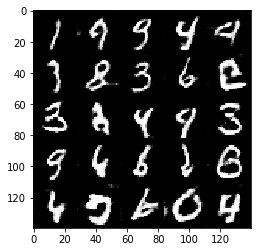

Epoch 2/2... Discriminator Loss: 1.5860... Generator Loss: 0.3389
Epoch 2/2... Discriminator Loss: 0.8430... Generator Loss: 1.7453
Epoch 2/2... Discriminator Loss: 0.6714... Generator Loss: 1.2475
Epoch 2/2... Discriminator Loss: 1.1612... Generator Loss: 0.6424
Epoch 2/2... Discriminator Loss: 1.5960... Generator Loss: 0.4013
Epoch 2/2... Discriminator Loss: 0.7548... Generator Loss: 0.9571
Epoch 2/2... Discriminator Loss: 0.8022... Generator Loss: 0.8875
Epoch 2/2... Discriminator Loss: 0.6461... Generator Loss: 1.0577
Epoch 2/2... Discriminator Loss: 0.5581... Generator Loss: 1.6872
Epoch 2/2... Discriminator Loss: 1.2918... Generator Loss: 0.5152


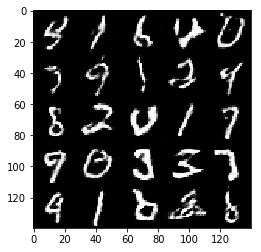

Epoch 2/2... Discriminator Loss: 0.8597... Generator Loss: 3.4990
Epoch 2/2... Discriminator Loss: 1.9994... Generator Loss: 0.3455
Epoch 2/2... Discriminator Loss: 1.3755... Generator Loss: 0.5219
Epoch 2/2... Discriminator Loss: 1.5039... Generator Loss: 0.4661
Epoch 2/2... Discriminator Loss: 0.6896... Generator Loss: 1.2253
Epoch 2/2... Discriminator Loss: 0.9592... Generator Loss: 0.9419
Epoch 2/2... Discriminator Loss: 0.7333... Generator Loss: 1.0684
Epoch 2/2... Discriminator Loss: 0.4647... Generator Loss: 1.4991
Epoch 2/2... Discriminator Loss: 1.1194... Generator Loss: 0.6877
Epoch 2/2... Discriminator Loss: 0.6387... Generator Loss: 1.9079


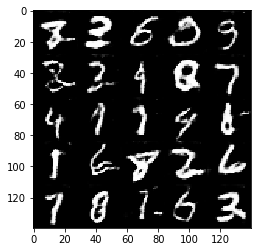

Epoch 2/2... Discriminator Loss: 1.5822... Generator Loss: 0.3423
Epoch 2/2... Discriminator Loss: 0.7780... Generator Loss: 0.9060
Epoch 2/2... Discriminator Loss: 2.1898... Generator Loss: 0.2285
Epoch 2/2... Discriminator Loss: 0.6140... Generator Loss: 2.8347
Epoch 2/2... Discriminator Loss: 1.4473... Generator Loss: 0.5151
Epoch 2/2... Discriminator Loss: 1.7331... Generator Loss: 0.2966
Epoch 2/2... Discriminator Loss: 0.9886... Generator Loss: 0.8419
Epoch 2/2... Discriminator Loss: 0.7890... Generator Loss: 0.8861
Epoch 2/2... Discriminator Loss: 0.6082... Generator Loss: 1.2818
Epoch 2/2... Discriminator Loss: 0.9923... Generator Loss: 0.6511


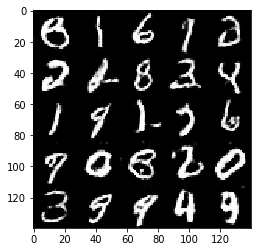

Epoch 2/2... Discriminator Loss: 0.3624... Generator Loss: 1.8485
Epoch 2/2... Discriminator Loss: 0.5410... Generator Loss: 1.1370
Epoch 2/2... Discriminator Loss: 0.4770... Generator Loss: 1.7192
Epoch 2/2... Discriminator Loss: 1.4894... Generator Loss: 0.4826
Epoch 2/2... Discriminator Loss: 0.6087... Generator Loss: 1.2511
Epoch 2/2... Discriminator Loss: 0.9199... Generator Loss: 0.8668
Epoch 2/2... Discriminator Loss: 1.4423... Generator Loss: 0.5291
Epoch 2/2... Discriminator Loss: 1.1662... Generator Loss: 0.5098
Epoch 2/2... Discriminator Loss: 1.4964... Generator Loss: 4.0192
Epoch 2/2... Discriminator Loss: 0.7573... Generator Loss: 0.8696


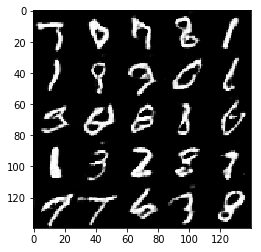

Epoch 2/2... Discriminator Loss: 0.5631... Generator Loss: 1.7220
Epoch 2/2... Discriminator Loss: 1.0988... Generator Loss: 0.8099
Epoch 2/2... Discriminator Loss: 0.5151... Generator Loss: 1.4932
Epoch 2/2... Discriminator Loss: 0.5471... Generator Loss: 1.2289
Epoch 2/2... Discriminator Loss: 0.4163... Generator Loss: 1.9468
Epoch 2/2... Discriminator Loss: 0.4405... Generator Loss: 1.5314
Epoch 2/2... Discriminator Loss: 0.9167... Generator Loss: 1.2617
Epoch 2/2... Discriminator Loss: 0.7773... Generator Loss: 0.9320
Epoch 2/2... Discriminator Loss: 0.6255... Generator Loss: 1.3050
Epoch 2/2... Discriminator Loss: 0.5547... Generator Loss: 3.3278


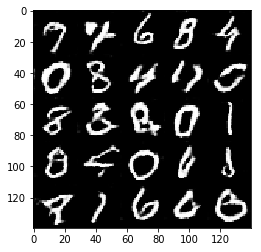

Epoch 2/2... Discriminator Loss: 0.5491... Generator Loss: 3.1347
Epoch 2/2... Discriminator Loss: 0.5386... Generator Loss: 1.6587
Epoch 2/2... Discriminator Loss: 1.2281... Generator Loss: 0.5901
Epoch 2/2... Discriminator Loss: 0.3939... Generator Loss: 2.8715
Epoch 2/2... Discriminator Loss: 1.1455... Generator Loss: 0.6297
Epoch 2/2... Discriminator Loss: 0.5921... Generator Loss: 1.5317
Epoch 2/2... Discriminator Loss: 0.6490... Generator Loss: 1.1961
Epoch 2/2... Discriminator Loss: 0.6307... Generator Loss: 2.5953
Epoch 2/2... Discriminator Loss: 0.7971... Generator Loss: 2.7543
Epoch 2/2... Discriminator Loss: 1.5910... Generator Loss: 0.3638


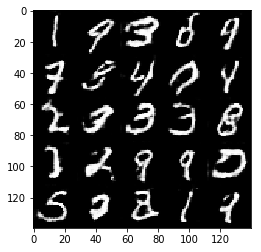

Epoch 2/2... Discriminator Loss: 0.5348... Generator Loss: 1.9583
Epoch 2/2... Discriminator Loss: 1.5961... Generator Loss: 0.3718
Epoch 2/2... Discriminator Loss: 0.4098... Generator Loss: 1.6978
Epoch 2/2... Discriminator Loss: 2.2585... Generator Loss: 0.2288
Epoch 2/2... Discriminator Loss: 0.8918... Generator Loss: 0.8886
Epoch 2/2... Discriminator Loss: 0.5828... Generator Loss: 1.3804
Epoch 2/2... Discriminator Loss: 1.4751... Generator Loss: 0.4324
Epoch 2/2... Discriminator Loss: 1.0079... Generator Loss: 2.5592
Epoch 2/2... Discriminator Loss: 1.4124... Generator Loss: 0.5614
Epoch 2/2... Discriminator Loss: 0.4900... Generator Loss: 1.4085


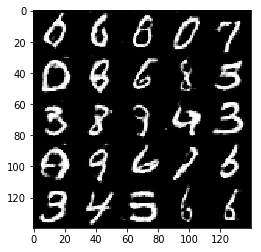

Epoch 2/2... Discriminator Loss: 0.8622... Generator Loss: 0.7727
Epoch 2/2... Discriminator Loss: 0.8536... Generator Loss: 0.7506
Epoch 2/2... Discriminator Loss: 0.4010... Generator Loss: 1.7340
Epoch 2/2... Discriminator Loss: 0.5971... Generator Loss: 1.0952
Epoch 2/2... Discriminator Loss: 0.4066... Generator Loss: 1.6487
Epoch 2/2... Discriminator Loss: 0.4896... Generator Loss: 2.0516
Epoch 2/2... Discriminator Loss: 0.4332... Generator Loss: 1.4896
Epoch 2/2... Discriminator Loss: 0.5631... Generator Loss: 3.5718
Epoch 2/2... Discriminator Loss: 0.5351... Generator Loss: 1.5679
Epoch 2/2... Discriminator Loss: 3.1360... Generator Loss: 0.2265


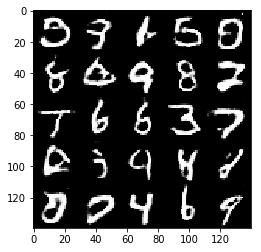

Epoch 2/2... Discriminator Loss: 0.8519... Generator Loss: 0.7931
Epoch 2/2... Discriminator Loss: 0.5161... Generator Loss: 2.0320
Epoch 2/2... Discriminator Loss: 0.9044... Generator Loss: 0.7598
Epoch 2/2... Discriminator Loss: 1.3128... Generator Loss: 3.9453
Epoch 2/2... Discriminator Loss: 0.4462... Generator Loss: 1.9080
Epoch 2/2... Discriminator Loss: 0.8085... Generator Loss: 2.6577
Epoch 2/2... Discriminator Loss: 0.6451... Generator Loss: 1.2974
Epoch 2/2... Discriminator Loss: 0.5000... Generator Loss: 1.8882
Epoch 2/2... Discriminator Loss: 1.9526... Generator Loss: 0.4046
Epoch 2/2... Discriminator Loss: 0.7347... Generator Loss: 1.0317


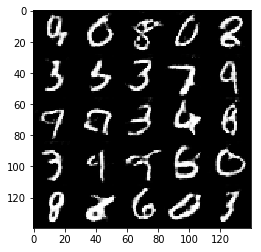

Epoch 2/2... Discriminator Loss: 1.7266... Generator Loss: 0.3528
Epoch 2/2... Discriminator Loss: 2.0650... Generator Loss: 0.3709
Epoch 2/2... Discriminator Loss: 0.6374... Generator Loss: 1.5398
Epoch 2/2... Discriminator Loss: 0.6298... Generator Loss: 1.4557
Epoch 2/2... Discriminator Loss: 0.7376... Generator Loss: 0.9002
Epoch 2/2... Discriminator Loss: 0.8910... Generator Loss: 0.7542
Epoch 2/2... Discriminator Loss: 0.8118... Generator Loss: 0.9085
Epoch 2/2... Discriminator Loss: 2.2885... Generator Loss: 0.3667
Epoch 2/2... Discriminator Loss: 0.5569... Generator Loss: 1.5020
Epoch 2/2... Discriminator Loss: 0.7280... Generator Loss: 1.5988


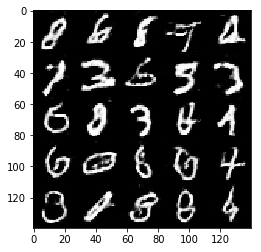

Epoch 2/2... Discriminator Loss: 0.8909... Generator Loss: 0.8439
Epoch 2/2... Discriminator Loss: 1.0766... Generator Loss: 0.7628
Epoch 2/2... Discriminator Loss: 1.2259... Generator Loss: 0.6627
Epoch 2/2... Discriminator Loss: 0.9079... Generator Loss: 0.6960
Epoch 2/2... Discriminator Loss: 0.4654... Generator Loss: 3.5314
Epoch 2/2... Discriminator Loss: 1.1659... Generator Loss: 4.8163
Epoch 2/2... Discriminator Loss: 0.3151... Generator Loss: 2.6209
Epoch 2/2... Discriminator Loss: 0.5534... Generator Loss: 1.2583
Epoch 2/2... Discriminator Loss: 1.4248... Generator Loss: 0.4393
Epoch 2/2... Discriminator Loss: 1.6635... Generator Loss: 0.4422


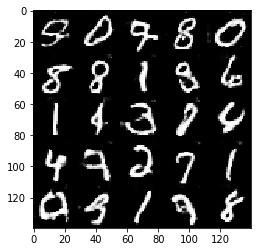

Epoch 2/2... Discriminator Loss: 0.3072... Generator Loss: 2.5368
Epoch 2/2... Discriminator Loss: 0.2879... Generator Loss: 2.2521
Epoch 2/2... Discriminator Loss: 0.4120... Generator Loss: 1.5552
Epoch 2/2... Discriminator Loss: 0.4956... Generator Loss: 2.5782
Epoch 2/2... Discriminator Loss: 1.7078... Generator Loss: 0.3812
Epoch 2/2... Discriminator Loss: 1.3762... Generator Loss: 0.5569
Epoch 2/2... Discriminator Loss: 1.1565... Generator Loss: 0.5361
Epoch 2/2... Discriminator Loss: 1.0235... Generator Loss: 0.7121
Epoch 2/2... Discriminator Loss: 0.8654... Generator Loss: 5.2494
Epoch 2/2... Discriminator Loss: 0.3025... Generator Loss: 1.9369


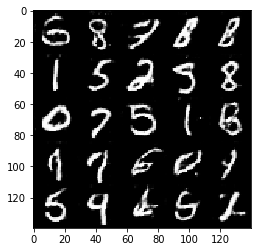

Epoch 2/2... Discriminator Loss: 1.0879... Generator Loss: 0.5614
Epoch 2/2... Discriminator Loss: 1.2932... Generator Loss: 0.7170
Epoch 2/2... Discriminator Loss: 0.6163... Generator Loss: 1.2748
Epoch 2/2... Discriminator Loss: 0.8084... Generator Loss: 1.0449
Epoch 2/2... Discriminator Loss: 0.7732... Generator Loss: 0.9750
Epoch 2/2... Discriminator Loss: 0.7901... Generator Loss: 0.9775
Epoch 2/2... Discriminator Loss: 0.8179... Generator Loss: 0.9260
Epoch 2/2... Discriminator Loss: 0.3806... Generator Loss: 1.8718
Epoch 2/2... Discriminator Loss: 0.3008... Generator Loss: 3.5558
Epoch 2/2... Discriminator Loss: 1.0216... Generator Loss: 0.9681


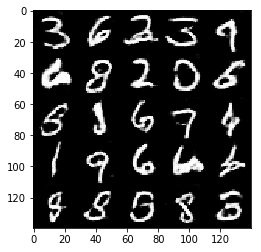

Epoch 2/2... Discriminator Loss: 0.3958... Generator Loss: 1.8002
Epoch 2/2... Discriminator Loss: 0.8629... Generator Loss: 0.7329
Epoch 2/2... Discriminator Loss: 0.8089... Generator Loss: 0.8998
Epoch 2/2... Discriminator Loss: 1.6441... Generator Loss: 0.3346
Epoch 2/2... Discriminator Loss: 0.5075... Generator Loss: 1.2909
Epoch 2/2... Discriminator Loss: 0.3535... Generator Loss: 1.9143
Epoch 2/2... Discriminator Loss: 0.9886... Generator Loss: 0.7242
Epoch 2/2... Discriminator Loss: 0.6882... Generator Loss: 1.1003
Epoch 2/2... Discriminator Loss: 0.9546... Generator Loss: 6.4361
Epoch 2/2... Discriminator Loss: 0.2125... Generator Loss: 3.5481


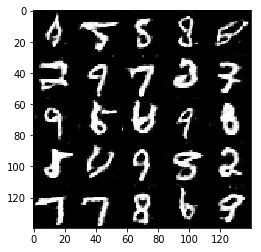

Epoch 2/2... Discriminator Loss: 0.8584... Generator Loss: 0.9494
Epoch 2/2... Discriminator Loss: 0.5984... Generator Loss: 1.2599
Epoch 2/2... Discriminator Loss: 1.0120... Generator Loss: 0.7736
Epoch 2/2... Discriminator Loss: 0.6410... Generator Loss: 1.0550
Epoch 2/2... Discriminator Loss: 0.9910... Generator Loss: 0.8310
Epoch 2/2... Discriminator Loss: 2.2218... Generator Loss: 0.2097
Epoch 2/2... Discriminator Loss: 0.4601... Generator Loss: 2.1582
Epoch 2/2... Discriminator Loss: 0.4623... Generator Loss: 1.4865
Epoch 2/2... Discriminator Loss: 1.5930... Generator Loss: 0.3515
Epoch 2/2... Discriminator Loss: 0.9133... Generator Loss: 0.8656


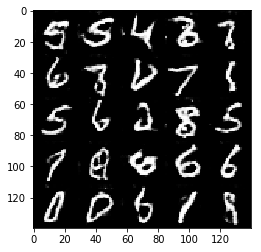

Epoch 2/2... Discriminator Loss: 0.4277... Generator Loss: 2.8909
Epoch 2/2... Discriminator Loss: 1.0591... Generator Loss: 0.6484
Epoch 2/2... Discriminator Loss: 0.6724... Generator Loss: 1.1321
Epoch 2/2... Discriminator Loss: 1.0747... Generator Loss: 0.6562
Epoch 2/2... Discriminator Loss: 0.3792... Generator Loss: 1.9648


In [12]:
batch_size = 32
z_dim = 100
learning_rate = 0.001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 0.2087... Generator Loss: 2.2926
Epoch 1/1... Discriminator Loss: 1.0781... Generator Loss: 5.5506
Epoch 1/1... Discriminator Loss: 0.5450... Generator Loss: 1.2712
Epoch 1/1... Discriminator Loss: 0.7632... Generator Loss: 12.7519
Epoch 1/1... Discriminator Loss: 9.0492... Generator Loss: 14.4372
Epoch 1/1... Discriminator Loss: 0.5827... Generator Loss: 2.2323
Epoch 1/1... Discriminator Loss: 0.2279... Generator Loss: 2.7950
Epoch 1/1... Discriminator Loss: 0.5254... Generator Loss: 1.4975
Epoch 1/1... Discriminator Loss: 0.6997... Generator Loss: 1.0403
Epoch 1/1... Discriminator Loss: 1.0398... Generator Loss: 0.6311


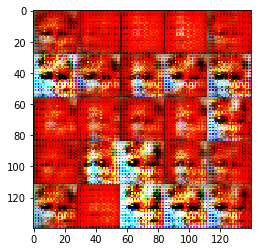

Epoch 1/1... Discriminator Loss: 0.5008... Generator Loss: 1.5180
Epoch 1/1... Discriminator Loss: 9.3957... Generator Loss: 14.6515
Epoch 1/1... Discriminator Loss: 1.0459... Generator Loss: 1.2773
Epoch 1/1... Discriminator Loss: 0.5677... Generator Loss: 1.1680
Epoch 1/1... Discriminator Loss: 0.9121... Generator Loss: 1.6391
Epoch 1/1... Discriminator Loss: 3.0867... Generator Loss: 5.3991
Epoch 1/1... Discriminator Loss: 0.1720... Generator Loss: 2.7159
Epoch 1/1... Discriminator Loss: 0.4143... Generator Loss: 8.5958
Epoch 1/1... Discriminator Loss: 0.0525... Generator Loss: 3.4328
Epoch 1/1... Discriminator Loss: 11.2111... Generator Loss: 15.2467


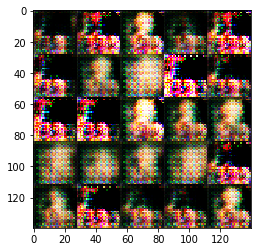

Epoch 1/1... Discriminator Loss: 1.2840... Generator Loss: 1.1878
Epoch 1/1... Discriminator Loss: 0.1808... Generator Loss: 2.2276
Epoch 1/1... Discriminator Loss: 2.4700... Generator Loss: 3.7577
Epoch 1/1... Discriminator Loss: 0.9818... Generator Loss: 1.0232
Epoch 1/1... Discriminator Loss: 0.4512... Generator Loss: 1.7698
Epoch 1/1... Discriminator Loss: 1.2323... Generator Loss: 0.5597
Epoch 1/1... Discriminator Loss: 1.0026... Generator Loss: 0.5144
Epoch 1/1... Discriminator Loss: 0.2173... Generator Loss: 1.9797
Epoch 1/1... Discriminator Loss: 0.9170... Generator Loss: 2.0822
Epoch 1/1... Discriminator Loss: 1.2047... Generator Loss: 0.6017


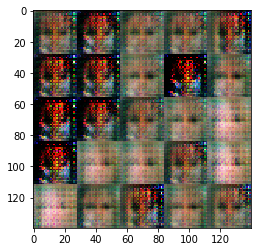

Epoch 1/1... Discriminator Loss: 0.4400... Generator Loss: 1.4046
Epoch 1/1... Discriminator Loss: 1.0319... Generator Loss: 0.7122
Epoch 1/1... Discriminator Loss: 1.3837... Generator Loss: 1.9543
Epoch 1/1... Discriminator Loss: 0.9835... Generator Loss: 2.2965
Epoch 1/1... Discriminator Loss: 1.3105... Generator Loss: 1.5339
Epoch 1/1... Discriminator Loss: 1.2002... Generator Loss: 1.7476
Epoch 1/1... Discriminator Loss: 1.8453... Generator Loss: 0.5511
Epoch 1/1... Discriminator Loss: 1.7073... Generator Loss: 2.1442
Epoch 1/1... Discriminator Loss: 1.4146... Generator Loss: 0.6311
Epoch 1/1... Discriminator Loss: 0.8086... Generator Loss: 1.2840


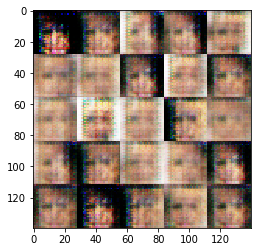

Epoch 1/1... Discriminator Loss: 1.7106... Generator Loss: 2.3947
Epoch 1/1... Discriminator Loss: 1.3575... Generator Loss: 0.4029
Epoch 1/1... Discriminator Loss: 1.6827... Generator Loss: 3.3879
Epoch 1/1... Discriminator Loss: 0.9406... Generator Loss: 1.4219
Epoch 1/1... Discriminator Loss: 2.6472... Generator Loss: 0.0912
Epoch 1/1... Discriminator Loss: 0.9957... Generator Loss: 1.2264
Epoch 1/1... Discriminator Loss: 1.3626... Generator Loss: 0.6658
Epoch 1/1... Discriminator Loss: 0.8778... Generator Loss: 1.0085
Epoch 1/1... Discriminator Loss: 1.3455... Generator Loss: 1.2338
Epoch 1/1... Discriminator Loss: 0.7752... Generator Loss: 1.0076


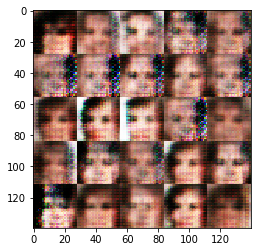

Epoch 1/1... Discriminator Loss: 1.0875... Generator Loss: 0.8534
Epoch 1/1... Discriminator Loss: 1.0082... Generator Loss: 1.0079
Epoch 1/1... Discriminator Loss: 1.4198... Generator Loss: 0.4141
Epoch 1/1... Discriminator Loss: 1.0526... Generator Loss: 1.2700
Epoch 1/1... Discriminator Loss: 1.2170... Generator Loss: 0.6398
Epoch 1/1... Discriminator Loss: 0.9552... Generator Loss: 0.7176
Epoch 1/1... Discriminator Loss: 0.9182... Generator Loss: 1.0741
Epoch 1/1... Discriminator Loss: 1.2294... Generator Loss: 0.8065
Epoch 1/1... Discriminator Loss: 1.3956... Generator Loss: 0.4422
Epoch 1/1... Discriminator Loss: 1.7739... Generator Loss: 0.2851


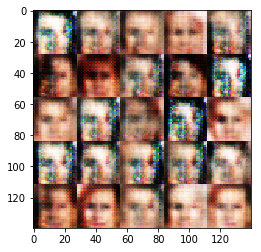

Epoch 1/1... Discriminator Loss: 0.8264... Generator Loss: 1.0462
Epoch 1/1... Discriminator Loss: 1.2544... Generator Loss: 1.0313
Epoch 1/1... Discriminator Loss: 1.2298... Generator Loss: 0.7774
Epoch 1/1... Discriminator Loss: 0.8141... Generator Loss: 1.0436
Epoch 1/1... Discriminator Loss: 0.6804... Generator Loss: 1.3795
Epoch 1/1... Discriminator Loss: 1.2479... Generator Loss: 1.0584
Epoch 1/1... Discriminator Loss: 1.1501... Generator Loss: 0.7459
Epoch 1/1... Discriminator Loss: 1.2370... Generator Loss: 0.5174
Epoch 1/1... Discriminator Loss: 0.9405... Generator Loss: 1.9660
Epoch 1/1... Discriminator Loss: 0.9610... Generator Loss: 0.7794


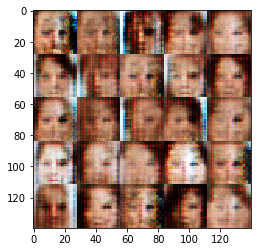

Epoch 1/1... Discriminator Loss: 1.0093... Generator Loss: 2.2251
Epoch 1/1... Discriminator Loss: 0.9999... Generator Loss: 1.0638
Epoch 1/1... Discriminator Loss: 0.8690... Generator Loss: 1.3198
Epoch 1/1... Discriminator Loss: 1.0290... Generator Loss: 2.0558
Epoch 1/1... Discriminator Loss: 1.3818... Generator Loss: 2.7561
Epoch 1/1... Discriminator Loss: 1.2628... Generator Loss: 0.8713
Epoch 1/1... Discriminator Loss: 1.1233... Generator Loss: 0.8276
Epoch 1/1... Discriminator Loss: 0.6791... Generator Loss: 1.2120
Epoch 1/1... Discriminator Loss: 0.9289... Generator Loss: 1.1795
Epoch 1/1... Discriminator Loss: 1.1001... Generator Loss: 0.7267


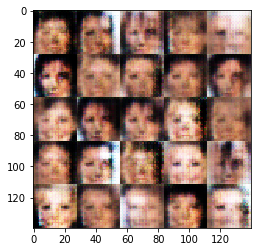

Epoch 1/1... Discriminator Loss: 0.9516... Generator Loss: 0.8178
Epoch 1/1... Discriminator Loss: 0.7819... Generator Loss: 0.9703
Epoch 1/1... Discriminator Loss: 1.8134... Generator Loss: 4.3586
Epoch 1/1... Discriminator Loss: 1.1931... Generator Loss: 2.1278
Epoch 1/1... Discriminator Loss: 1.7141... Generator Loss: 0.3529
Epoch 1/1... Discriminator Loss: 1.2557... Generator Loss: 0.6479
Epoch 1/1... Discriminator Loss: 0.8920... Generator Loss: 0.8539
Epoch 1/1... Discriminator Loss: 1.1032... Generator Loss: 0.6203
Epoch 1/1... Discriminator Loss: 1.2076... Generator Loss: 1.9298
Epoch 1/1... Discriminator Loss: 1.2498... Generator Loss: 0.4895


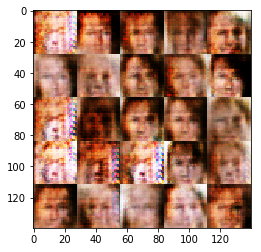

Epoch 1/1... Discriminator Loss: 1.2994... Generator Loss: 0.6810
Epoch 1/1... Discriminator Loss: 1.1921... Generator Loss: 0.6929
Epoch 1/1... Discriminator Loss: 1.0676... Generator Loss: 0.7747
Epoch 1/1... Discriminator Loss: 1.3223... Generator Loss: 1.5954
Epoch 1/1... Discriminator Loss: 1.2513... Generator Loss: 1.5752
Epoch 1/1... Discriminator Loss: 1.3995... Generator Loss: 1.6706
Epoch 1/1... Discriminator Loss: 0.9899... Generator Loss: 1.2881
Epoch 1/1... Discriminator Loss: 1.3413... Generator Loss: 1.5849
Epoch 1/1... Discriminator Loss: 1.8933... Generator Loss: 0.2323
Epoch 1/1... Discriminator Loss: 0.9656... Generator Loss: 0.7897


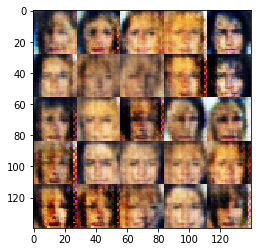

Epoch 1/1... Discriminator Loss: 1.0517... Generator Loss: 0.9647
Epoch 1/1... Discriminator Loss: 1.1420... Generator Loss: 1.4313
Epoch 1/1... Discriminator Loss: 0.8397... Generator Loss: 1.1732
Epoch 1/1... Discriminator Loss: 0.9164... Generator Loss: 0.8065
Epoch 1/1... Discriminator Loss: 1.3135... Generator Loss: 0.8524
Epoch 1/1... Discriminator Loss: 1.4899... Generator Loss: 0.3709
Epoch 1/1... Discriminator Loss: 1.0160... Generator Loss: 1.4340
Epoch 1/1... Discriminator Loss: 1.0357... Generator Loss: 1.8980
Epoch 1/1... Discriminator Loss: 1.1032... Generator Loss: 0.9034
Epoch 1/1... Discriminator Loss: 0.8218... Generator Loss: 1.4065


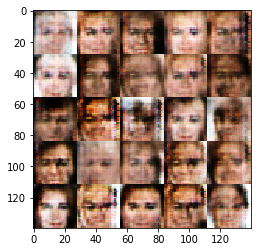

Epoch 1/1... Discriminator Loss: 0.9345... Generator Loss: 1.5480
Epoch 1/1... Discriminator Loss: 0.8913... Generator Loss: 1.0284
Epoch 1/1... Discriminator Loss: 0.8791... Generator Loss: 1.2170
Epoch 1/1... Discriminator Loss: 1.0235... Generator Loss: 0.7688
Epoch 1/1... Discriminator Loss: 0.8467... Generator Loss: 0.9942
Epoch 1/1... Discriminator Loss: 0.9539... Generator Loss: 0.7271
Epoch 1/1... Discriminator Loss: 1.3197... Generator Loss: 0.5051
Epoch 1/1... Discriminator Loss: 1.3090... Generator Loss: 1.7468
Epoch 1/1... Discriminator Loss: 1.0992... Generator Loss: 1.1413
Epoch 1/1... Discriminator Loss: 1.4650... Generator Loss: 1.2399


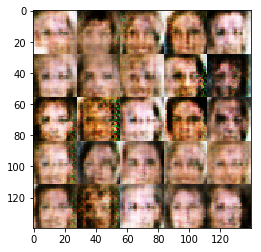

Epoch 1/1... Discriminator Loss: 0.9990... Generator Loss: 1.0737
Epoch 1/1... Discriminator Loss: 1.2558... Generator Loss: 2.3078
Epoch 1/1... Discriminator Loss: 1.3056... Generator Loss: 0.7117
Epoch 1/1... Discriminator Loss: 0.9659... Generator Loss: 0.9626
Epoch 1/1... Discriminator Loss: 0.9919... Generator Loss: 0.9005
Epoch 1/1... Discriminator Loss: 0.9960... Generator Loss: 0.9994
Epoch 1/1... Discriminator Loss: 1.1578... Generator Loss: 0.7631
Epoch 1/1... Discriminator Loss: 1.2000... Generator Loss: 0.6154
Epoch 1/1... Discriminator Loss: 1.2735... Generator Loss: 1.6534
Epoch 1/1... Discriminator Loss: 0.8669... Generator Loss: 1.4547


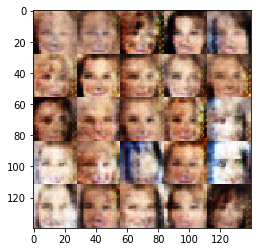

Epoch 1/1... Discriminator Loss: 0.8322... Generator Loss: 1.2689
Epoch 1/1... Discriminator Loss: 1.6296... Generator Loss: 0.3967
Epoch 1/1... Discriminator Loss: 0.8297... Generator Loss: 1.1574
Epoch 1/1... Discriminator Loss: 1.4565... Generator Loss: 1.7080
Epoch 1/1... Discriminator Loss: 1.5412... Generator Loss: 0.4394
Epoch 1/1... Discriminator Loss: 0.9089... Generator Loss: 1.2992
Epoch 1/1... Discriminator Loss: 1.4546... Generator Loss: 0.4262
Epoch 1/1... Discriminator Loss: 0.9677... Generator Loss: 0.9186
Epoch 1/1... Discriminator Loss: 1.3198... Generator Loss: 0.5629
Epoch 1/1... Discriminator Loss: 0.7339... Generator Loss: 1.5265


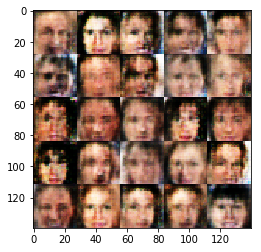

Epoch 1/1... Discriminator Loss: 1.2112... Generator Loss: 0.5158
Epoch 1/1... Discriminator Loss: 0.9881... Generator Loss: 1.1393
Epoch 1/1... Discriminator Loss: 1.0929... Generator Loss: 1.2867
Epoch 1/1... Discriminator Loss: 0.9639... Generator Loss: 0.8762
Epoch 1/1... Discriminator Loss: 1.3141... Generator Loss: 0.4548
Epoch 1/1... Discriminator Loss: 1.0786... Generator Loss: 0.8434
Epoch 1/1... Discriminator Loss: 1.0767... Generator Loss: 0.7260
Epoch 1/1... Discriminator Loss: 0.8563... Generator Loss: 1.4339
Epoch 1/1... Discriminator Loss: 1.2427... Generator Loss: 0.6229
Epoch 1/1... Discriminator Loss: 1.0790... Generator Loss: 0.5947


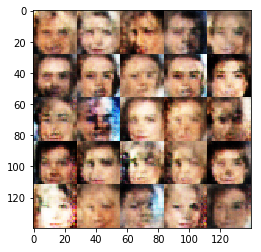

Epoch 1/1... Discriminator Loss: 0.9689... Generator Loss: 1.0218
Epoch 1/1... Discriminator Loss: 1.0047... Generator Loss: 0.7468
Epoch 1/1... Discriminator Loss: 1.1241... Generator Loss: 0.9630
Epoch 1/1... Discriminator Loss: 0.8436... Generator Loss: 1.1017
Epoch 1/1... Discriminator Loss: 0.8531... Generator Loss: 1.2086
Epoch 1/1... Discriminator Loss: 1.1436... Generator Loss: 0.8172
Epoch 1/1... Discriminator Loss: 1.0919... Generator Loss: 1.7784
Epoch 1/1... Discriminator Loss: 1.1137... Generator Loss: 1.7472
Epoch 1/1... Discriminator Loss: 1.0807... Generator Loss: 0.8282
Epoch 1/1... Discriminator Loss: 0.9852... Generator Loss: 0.8016


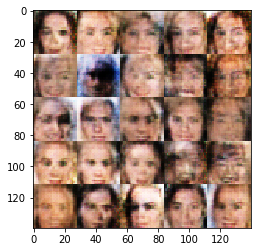

Epoch 1/1... Discriminator Loss: 1.3764... Generator Loss: 0.5659
Epoch 1/1... Discriminator Loss: 1.9802... Generator Loss: 2.8730
Epoch 1/1... Discriminator Loss: 0.8949... Generator Loss: 1.0852
Epoch 1/1... Discriminator Loss: 0.9717... Generator Loss: 1.1115
Epoch 1/1... Discriminator Loss: 0.9210... Generator Loss: 1.1481
Epoch 1/1... Discriminator Loss: 1.1177... Generator Loss: 0.8020
Epoch 1/1... Discriminator Loss: 1.2124... Generator Loss: 1.5676
Epoch 1/1... Discriminator Loss: 1.0408... Generator Loss: 0.7895
Epoch 1/1... Discriminator Loss: 1.2481... Generator Loss: 0.9422
Epoch 1/1... Discriminator Loss: 1.1342... Generator Loss: 1.0650


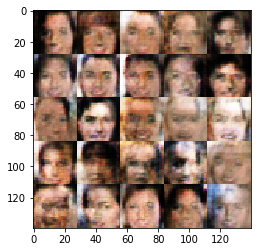

Epoch 1/1... Discriminator Loss: 1.2548... Generator Loss: 0.6437
Epoch 1/1... Discriminator Loss: 1.2422... Generator Loss: 0.7858
Epoch 1/1... Discriminator Loss: 1.1312... Generator Loss: 0.6517
Epoch 1/1... Discriminator Loss: 0.9637... Generator Loss: 1.4565
Epoch 1/1... Discriminator Loss: 1.2174... Generator Loss: 1.3434
Epoch 1/1... Discriminator Loss: 1.1083... Generator Loss: 0.6893
Epoch 1/1... Discriminator Loss: 1.3003... Generator Loss: 1.3382
Epoch 1/1... Discriminator Loss: 1.0535... Generator Loss: 0.8756
Epoch 1/1... Discriminator Loss: 1.2807... Generator Loss: 0.4812
Epoch 1/1... Discriminator Loss: 1.0006... Generator Loss: 1.1659


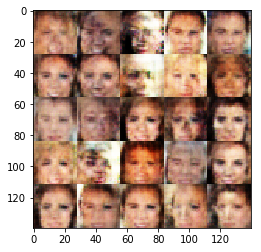

Epoch 1/1... Discriminator Loss: 0.9770... Generator Loss: 0.7531
Epoch 1/1... Discriminator Loss: 1.2064... Generator Loss: 1.5963
Epoch 1/1... Discriminator Loss: 0.9643... Generator Loss: 1.8272
Epoch 1/1... Discriminator Loss: 1.1557... Generator Loss: 1.0215
Epoch 1/1... Discriminator Loss: 1.0915... Generator Loss: 0.5881
Epoch 1/1... Discriminator Loss: 1.1218... Generator Loss: 0.9428
Epoch 1/1... Discriminator Loss: 1.2400... Generator Loss: 0.9539
Epoch 1/1... Discriminator Loss: 1.1620... Generator Loss: 0.5131
Epoch 1/1... Discriminator Loss: 1.1436... Generator Loss: 0.9643
Epoch 1/1... Discriminator Loss: 1.0058... Generator Loss: 1.3189


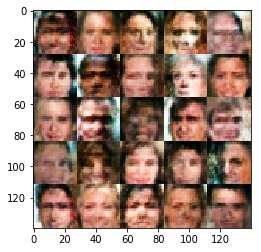

Epoch 1/1... Discriminator Loss: 1.3752... Generator Loss: 0.5389
Epoch 1/1... Discriminator Loss: 1.0762... Generator Loss: 1.0014
Epoch 1/1... Discriminator Loss: 0.9129... Generator Loss: 0.8887
Epoch 1/1... Discriminator Loss: 1.8453... Generator Loss: 0.2736
Epoch 1/1... Discriminator Loss: 1.0253... Generator Loss: 0.7705
Epoch 1/1... Discriminator Loss: 1.0956... Generator Loss: 0.8672
Epoch 1/1... Discriminator Loss: 1.0109... Generator Loss: 1.2943
Epoch 1/1... Discriminator Loss: 1.1486... Generator Loss: 1.2927
Epoch 1/1... Discriminator Loss: 1.0888... Generator Loss: 0.8086
Epoch 1/1... Discriminator Loss: 0.9488... Generator Loss: 0.7489


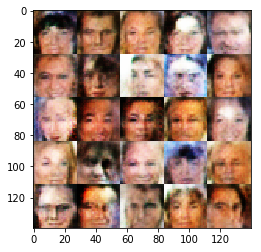

Epoch 1/1... Discriminator Loss: 1.5677... Generator Loss: 0.3427
Epoch 1/1... Discriminator Loss: 0.9791... Generator Loss: 1.1885
Epoch 1/1... Discriminator Loss: 1.3071... Generator Loss: 2.0196
Epoch 1/1... Discriminator Loss: 0.7385... Generator Loss: 1.0902
Epoch 1/1... Discriminator Loss: 1.0298... Generator Loss: 0.7420
Epoch 1/1... Discriminator Loss: 0.8816... Generator Loss: 1.5937
Epoch 1/1... Discriminator Loss: 1.1671... Generator Loss: 0.5825
Epoch 1/1... Discriminator Loss: 0.9976... Generator Loss: 0.6824
Epoch 1/1... Discriminator Loss: 1.2029... Generator Loss: 1.1014
Epoch 1/1... Discriminator Loss: 0.8454... Generator Loss: 1.0548


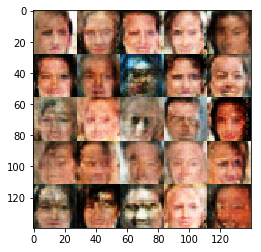

Epoch 1/1... Discriminator Loss: 0.9555... Generator Loss: 1.1427
Epoch 1/1... Discriminator Loss: 1.4216... Generator Loss: 1.2613
Epoch 1/1... Discriminator Loss: 1.1512... Generator Loss: 0.5872
Epoch 1/1... Discriminator Loss: 1.0570... Generator Loss: 1.2345
Epoch 1/1... Discriminator Loss: 1.0675... Generator Loss: 0.6997
Epoch 1/1... Discriminator Loss: 1.1645... Generator Loss: 0.6662
Epoch 1/1... Discriminator Loss: 1.1621... Generator Loss: 0.6142
Epoch 1/1... Discriminator Loss: 0.8584... Generator Loss: 1.1233
Epoch 1/1... Discriminator Loss: 0.8967... Generator Loss: 1.0587
Epoch 1/1... Discriminator Loss: 1.2279... Generator Loss: 1.4575


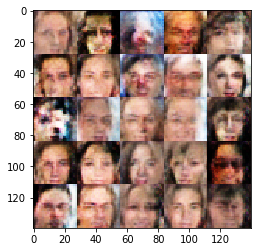

Epoch 1/1... Discriminator Loss: 0.9887... Generator Loss: 1.2055
Epoch 1/1... Discriminator Loss: 1.1543... Generator Loss: 0.6923
Epoch 1/1... Discriminator Loss: 1.2573... Generator Loss: 0.6385
Epoch 1/1... Discriminator Loss: 1.1723... Generator Loss: 1.2091
Epoch 1/1... Discriminator Loss: 1.1686... Generator Loss: 0.5492
Epoch 1/1... Discriminator Loss: 1.2647... Generator Loss: 1.1295
Epoch 1/1... Discriminator Loss: 1.1236... Generator Loss: 1.4939
Epoch 1/1... Discriminator Loss: 1.2533... Generator Loss: 1.3941
Epoch 1/1... Discriminator Loss: 1.0342... Generator Loss: 0.7017
Epoch 1/1... Discriminator Loss: 1.4281... Generator Loss: 1.2290


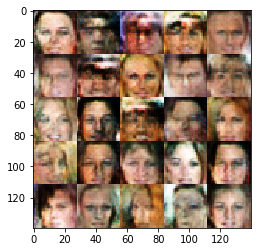

Epoch 1/1... Discriminator Loss: 1.2663... Generator Loss: 0.6193
Epoch 1/1... Discriminator Loss: 1.6531... Generator Loss: 0.3287
Epoch 1/1... Discriminator Loss: 1.1222... Generator Loss: 0.6331
Epoch 1/1... Discriminator Loss: 1.2378... Generator Loss: 1.0573
Epoch 1/1... Discriminator Loss: 1.1023... Generator Loss: 0.7987
Epoch 1/1... Discriminator Loss: 1.4385... Generator Loss: 0.4114
Epoch 1/1... Discriminator Loss: 1.0602... Generator Loss: 0.9016
Epoch 1/1... Discriminator Loss: 1.2065... Generator Loss: 0.5358
Epoch 1/1... Discriminator Loss: 0.9674... Generator Loss: 0.9919
Epoch 1/1... Discriminator Loss: 1.1426... Generator Loss: 0.7826


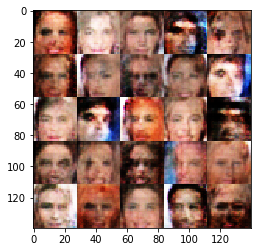

Epoch 1/1... Discriminator Loss: 0.9238... Generator Loss: 0.8934
Epoch 1/1... Discriminator Loss: 1.0800... Generator Loss: 0.9569
Epoch 1/1... Discriminator Loss: 1.2949... Generator Loss: 0.5427
Epoch 1/1... Discriminator Loss: 1.0174... Generator Loss: 0.8259
Epoch 1/1... Discriminator Loss: 1.6871... Generator Loss: 0.3057
Epoch 1/1... Discriminator Loss: 1.3802... Generator Loss: 0.4878
Epoch 1/1... Discriminator Loss: 1.1497... Generator Loss: 0.6401
Epoch 1/1... Discriminator Loss: 1.0009... Generator Loss: 0.8717
Epoch 1/1... Discriminator Loss: 1.1898... Generator Loss: 0.6944
Epoch 1/1... Discriminator Loss: 2.1162... Generator Loss: 0.2089


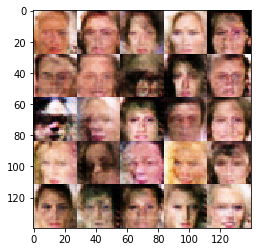

Epoch 1/1... Discriminator Loss: 1.2109... Generator Loss: 0.8756
Epoch 1/1... Discriminator Loss: 1.0283... Generator Loss: 0.8096
Epoch 1/1... Discriminator Loss: 0.9695... Generator Loss: 1.0062
Epoch 1/1... Discriminator Loss: 1.3152... Generator Loss: 0.4853
Epoch 1/1... Discriminator Loss: 1.1407... Generator Loss: 1.2575
Epoch 1/1... Discriminator Loss: 1.2908... Generator Loss: 0.5635
Epoch 1/1... Discriminator Loss: 1.0046... Generator Loss: 1.1581
Epoch 1/1... Discriminator Loss: 1.0175... Generator Loss: 1.8867
Epoch 1/1... Discriminator Loss: 0.9108... Generator Loss: 0.7902
Epoch 1/1... Discriminator Loss: 0.9193... Generator Loss: 2.0713


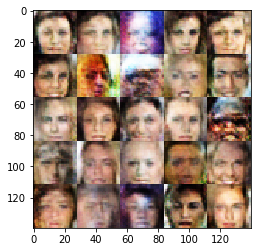

Epoch 1/1... Discriminator Loss: 0.9323... Generator Loss: 1.2932
Epoch 1/1... Discriminator Loss: 0.9205... Generator Loss: 1.1242
Epoch 1/1... Discriminator Loss: 0.9215... Generator Loss: 0.9307
Epoch 1/1... Discriminator Loss: 1.0294... Generator Loss: 0.9403
Epoch 1/1... Discriminator Loss: 1.0208... Generator Loss: 1.1043
Epoch 1/1... Discriminator Loss: 0.7882... Generator Loss: 0.8858
Epoch 1/1... Discriminator Loss: 1.5710... Generator Loss: 0.3620
Epoch 1/1... Discriminator Loss: 1.1529... Generator Loss: 1.1145
Epoch 1/1... Discriminator Loss: 1.0246... Generator Loss: 1.2066
Epoch 1/1... Discriminator Loss: 1.0898... Generator Loss: 0.7960


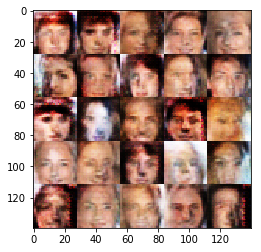

Epoch 1/1... Discriminator Loss: 0.8324... Generator Loss: 1.0742
Epoch 1/1... Discriminator Loss: 0.8913... Generator Loss: 1.0004
Epoch 1/1... Discriminator Loss: 0.8498... Generator Loss: 1.4302
Epoch 1/1... Discriminator Loss: 1.1279... Generator Loss: 0.7904
Epoch 1/1... Discriminator Loss: 1.1275... Generator Loss: 0.8048
Epoch 1/1... Discriminator Loss: 1.2329... Generator Loss: 1.0273
Epoch 1/1... Discriminator Loss: 1.0430... Generator Loss: 1.6719
Epoch 1/1... Discriminator Loss: 0.8887... Generator Loss: 1.1914
Epoch 1/1... Discriminator Loss: 1.3996... Generator Loss: 0.4413
Epoch 1/1... Discriminator Loss: 1.1851... Generator Loss: 0.4876


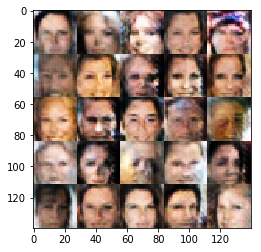

Epoch 1/1... Discriminator Loss: 0.8225... Generator Loss: 1.2947
Epoch 1/1... Discriminator Loss: 1.3526... Generator Loss: 0.4781
Epoch 1/1... Discriminator Loss: 1.0846... Generator Loss: 1.2787
Epoch 1/1... Discriminator Loss: 1.4433... Generator Loss: 0.4481
Epoch 1/1... Discriminator Loss: 1.1161... Generator Loss: 0.7074
Epoch 1/1... Discriminator Loss: 1.3284... Generator Loss: 0.5199
Epoch 1/1... Discriminator Loss: 1.0984... Generator Loss: 0.7758
Epoch 1/1... Discriminator Loss: 1.0206... Generator Loss: 1.0992
Epoch 1/1... Discriminator Loss: 1.1961... Generator Loss: 0.7244
Epoch 1/1... Discriminator Loss: 1.0261... Generator Loss: 1.2028


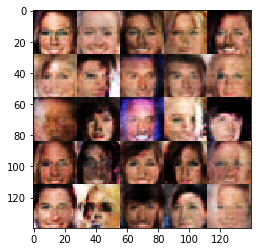

Epoch 1/1... Discriminator Loss: 1.2250... Generator Loss: 0.5738
Epoch 1/1... Discriminator Loss: 1.1201... Generator Loss: 0.8528
Epoch 1/1... Discriminator Loss: 1.6449... Generator Loss: 2.4648
Epoch 1/1... Discriminator Loss: 0.9919... Generator Loss: 1.3094
Epoch 1/1... Discriminator Loss: 0.7614... Generator Loss: 1.5092
Epoch 1/1... Discriminator Loss: 1.4251... Generator Loss: 1.3934
Epoch 1/1... Discriminator Loss: 0.9309... Generator Loss: 1.7872
Epoch 1/1... Discriminator Loss: 1.0257... Generator Loss: 0.8799
Epoch 1/1... Discriminator Loss: 1.1637... Generator Loss: 0.6718
Epoch 1/1... Discriminator Loss: 0.8440... Generator Loss: 0.9992


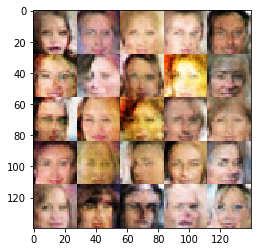

Epoch 1/1... Discriminator Loss: 1.0985... Generator Loss: 0.9481
Epoch 1/1... Discriminator Loss: 1.7117... Generator Loss: 0.3106
Epoch 1/1... Discriminator Loss: 0.9091... Generator Loss: 1.0856
Epoch 1/1... Discriminator Loss: 1.1760... Generator Loss: 0.7265
Epoch 1/1... Discriminator Loss: 1.1094... Generator Loss: 0.8945
Epoch 1/1... Discriminator Loss: 0.8899... Generator Loss: 1.1072
Epoch 1/1... Discriminator Loss: 1.1550... Generator Loss: 0.6495
Epoch 1/1... Discriminator Loss: 1.0809... Generator Loss: 1.1491
Epoch 1/1... Discriminator Loss: 1.0616... Generator Loss: 1.4279
Epoch 1/1... Discriminator Loss: 1.3480... Generator Loss: 1.2026


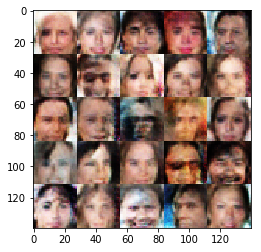

Epoch 1/1... Discriminator Loss: 1.1614... Generator Loss: 0.5911
Epoch 1/1... Discriminator Loss: 1.2155... Generator Loss: 0.6369
Epoch 1/1... Discriminator Loss: 1.3332... Generator Loss: 0.4768
Epoch 1/1... Discriminator Loss: 1.2608... Generator Loss: 0.6454
Epoch 1/1... Discriminator Loss: 1.2608... Generator Loss: 0.5737
Epoch 1/1... Discriminator Loss: 1.4190... Generator Loss: 0.4972


In [13]:
batch_size = 64
z_dim = 100
learning_rate = 0.002
beta1 = 0.5



"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.